In [1]:
import pytest
import torch
from torch import einsum, nn
import triton
import triton.language as tl
from einops import rearrange
from triton_testing.multihead_attention import multihead_flash_attention
from triton_testing.multiquery_attention import multiquery_flash_attention
from triton_testing.query_norm import fused_query_norm, naive_query_norm
from triton_testing.fused_multiquery_querynorm import multiquery_querynorm_flash_attention

## Multiquery Attention

The following blocks compare a triton implementation of multiquery attention with a baseline flashattention implementation (keys and values are repeated on all heads to get equivalent outputs from flashattention)

In [2]:
def test_multiquery_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float16):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    dout = torch.randn_like(q)
    # triton implementation
    tri_out = multiquery_flash_attention(q, k, v)
    tri_out.backward(dout)
    tri_dv, v.grad = v.grad.clone(), None
    tri_dk, k.grad = k.grad.clone(), None
    tri_dq, q.grad = q.grad.clone(), None
    # reference implementation
    reshaped_k = k.reshape(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    reshaped_v = v.reshape(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
    ref_out = multihead_flash_attention(q,reshaped_k,reshaped_v)
    ref_out.backward(dout)
    ref_dv, v.grad = v.grad.clone(), None
    ref_dk, k.grad = k.grad.clone(), None
    ref_dq, q.grad = q.grad.clone(), None
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)
    triton.testing.assert_almost_equal(ref_dq, tri_dq)
    triton.testing.assert_almost_equal(ref_dk, tri_dk)
    triton.testing.assert_almost_equal(ref_dv, tri_dv)
    print("Passed all equality checks")

In [3]:
test_multiquery_op(3, 2, 2048, 64)

Passed all equality checks


Now comparing the forward and backward passes. The forward passes of both implementations are quite similar but the backward pass of multiquery attention requires a reduction over the gradients of k and v

In [4]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['multiquery_flash_attention','multihead_flash_attention'],
    line_names=['Multiquery Attention','Multihead Attention'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd','bwd']]


@triton.testing.perf_report(configs)
def bench_flash_multiquery_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    if provider == "multiquery_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        fn = lambda: multiquery_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "multihead_flash_attention":
        q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
        k = k.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        v = v.view(BATCH, N_CTX, 1, D_HEAD).transpose(1, 2).repeat(1,H,1,1) # (B, nh, T, hs)
        fn = lambda: multihead_flash_attention(q, k, v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


fused-attention-batch4-head24-d64-fwd:
     N_CTX  Multiquery Attention  Multihead Attention
0   1024.0              0.199281             0.184896
1   2048.0              0.533217             0.551505
2   4096.0              1.859912             1.887508
3   8192.0              6.940891             6.992750
4  16384.0             26.789545            26.867712
5  32768.0            105.344002           105.391106
fused-attention-batch4-head24-d64-bwd:
     N_CTX  Multiquery Attention  Multihead Attention
0   1024.0              1.294473             0.604793
1   2048.0              2.881691             1.893316
2   4096.0              7.451884             6.439731
3   8192.0             23.743486            23.463936
4  16384.0             87.285759            90.458115
5  32768.0            335.473663           358.108154


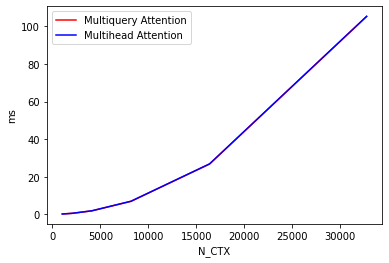

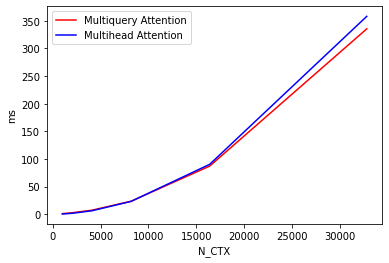

In [5]:
bench_flash_multiquery_attention.run(save_path='.', print_data=True)

## QueryNorm

QueryNorm is a custom norm operation similar to LN but with weights and bias scalars per head instead of per d_head element. This is to be applied to the queries of a multihead/query attention block. The following blocks compare the a triton implementation of this norm with a standard pytorch implementation

In [6]:
def test_querynorm_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float32):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn((1,H,1,1), dtype=dtype, device="cuda", requires_grad=True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-6
    # naive torch implementation
    naive_out = naive_query_norm(q, w, b, eps)
    # triton implementation
    tri_out = fused_query_norm(q, w.flatten(), b.flatten(), eps)
    tri_out.backward(dy, retain_graph=True)
    dq_tri, dw_tri, db_tri = [_.grad.clone() for _ in [q, w, b]]
    q.grad, w.grad, b.grad = None, None, None
    # backward pass (torch)
    naive_out.backward(dy, retain_graph=True)
    dq_ref, dw_ref, db_ref = [_.grad.clone() for _ in [q, w, b]]
    # compare
    triton.testing.assert_almost_equal(naive_out, tri_out)
    triton.testing.assert_almost_equal(dq_tri, dq_ref)
    triton.testing.assert_almost_equal(db_tri, db_ref)
    triton.testing.assert_almost_equal(dw_tri, dw_ref)
    print("Passed all equality checks")

In [7]:
test_querynorm_op(3, 2, 2048, 64)

Passed all equality checks


In [8]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
configs = [triton.testing.Benchmark(
    x_names=['D_HEAD'],
    x_vals=[512 * i for i in range(2, 16)],
    line_arg='provider',
    line_vals=['triton', 'torch'],
    line_names=['Triton QueryNorm', 'Torch QueryNorm'],
    styles=[('blue', '-'), ('green', '-')],
    ylabel='GB/s',
    plot_name=f'query-norm-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'N_CTX': N_CTX, 'dtype': torch.float16, 'mode': mode}
) for mode in ['forward', 'backward']]

@triton.testing.perf_report(configs)
def bench_query_norm(BATCH, H, N_CTX, D_HEAD, dtype, provider, mode='forward', eps=1e-5, device='cuda'):
    # create data
    q_shape = (BATCH, H, N_CTX, D_HEAD)
    w_shape = (1,H,1,1)
    w = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(w_shape, dtype=dtype, device="cuda", requires_grad=True)
    q = torch.randn(q_shape, dtype=dtype, device='cuda')
    q.requires_grad_(True)
    dy = .1 * torch.randn_like(q)
    eps = 1e-5
    # utility functions
    if provider == 'triton':
        y_fwd = lambda: fused_query_norm(q, w.flatten(), b.flatten(), eps)
    if provider == 'torch':
        y_fwd = lambda: naive_query_norm(q, w, b, eps)
    # forward pass
    if mode == 'forward':
        gbps = lambda ms: 2 * q.numel() * q.element_size() / ms * 1e-6
        ms, min_ms, max_ms = triton.testing.do_bench(y_fwd, rep=500)
    # backward pass
    if mode == 'backward':
        gbps = lambda ms: 3 * q.numel() * q.element_size() / ms * 1e-6
        y = y_fwd()
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True),
                                                     grad_to_none=[q], rep=500)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


query-norm-forward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1377.289009       185.086374
1   1536.0       1370.090626       187.305176
2   2048.0       1388.229464       187.894393
3   2560.0       1382.616033       188.448201
4   3072.0       1378.898898       189.243287
5   3584.0       1380.397157       189.553888
6   4096.0       1380.310729       187.346088
7   4608.0       1394.382978       190.296506
8   5120.0       1388.474620       190.677916
9   5632.0       1332.524939       189.626297
10  6144.0       1382.940250       190.281150
11  6656.0       1382.690839       187.053868
12  7168.0       1381.609834       190.696405
13  7680.0       1331.431090       190.714906
query-norm-backward:
    D_HEAD  Triton QueryNorm  Torch QueryNorm
0   1024.0       1173.779141        99.670317
1   1536.0       1117.090941       100.230657
2   2048.0       1260.307658       100.588192
3   2560.0       1228.288270       100.611355
4   3072.0       1287.356868       100.

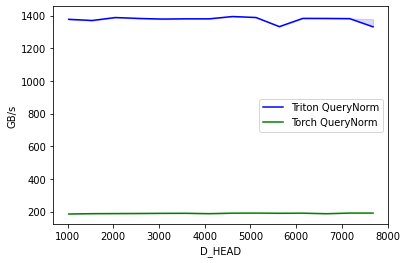

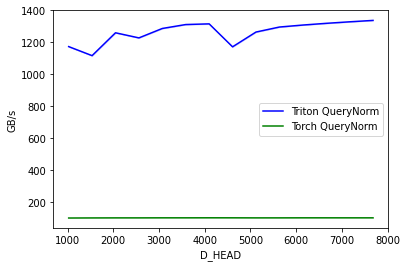

In [9]:
bench_query_norm.run(save_path='.', print_data=True)

## Fusing Multiquery Attention With QueryNorm

We can also fuse multiquery attention with query norm to avoid launching two seperate kernels. The following block compares a fused multiquery attention + QueryNorm kernel with a baseline of composing the two triton kernels we saw previously

In [2]:
def test_multiquery_querynorm_op(BATCH, H, N_CTX, D_HEAD, dtype=torch.float16):
    torch.manual_seed(20)
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    eps = 1e-6
    # triton implementation
    tri_out = multiquery_querynorm_flash_attention(q, k, v, w, b, eps)
    # reference implementation
    ref_out = multiquery_flash_attention(fused_query_norm(q, w, b, eps),k,v)
    # compare
    triton.testing.assert_almost_equal(ref_out, tri_out)
    print("Passed all equality checks")

In [3]:
test_multiquery_querynorm_op(3, 2, 2048, 64)

Passed all equality checks


In [2]:
BATCH, N_HEADS, N_CTX, D_HEAD = 4, 24, 2048, 64
# vary seq length for fixed head and batch=4
configs = [triton.testing.Benchmark(
    x_names=['N_CTX'],
    x_vals=[2**i for i in range(10, 16)],
    line_arg='provider',
    line_vals=['fused_multiquery_querynorm','unfused_multiquery_querynorm'],
    line_names=['Fused Multiquery QueryNorm','Unfused Multiquery QueryNorm'],
    styles=[('red', '-'), ('blue', '-'), ('green', '-')],
    ylabel='ms',
    plot_name=f'fused-attention-batch{BATCH}-head{N_HEADS}-d{D_HEAD}-{mode}',
    args={'H': N_HEADS, 'BATCH': BATCH, 'D_HEAD': D_HEAD, 'dtype': torch.float16, 'mode': mode}
) for mode in ['fwd','bwd']]


@triton.testing.perf_report(configs)
def bench_multiquery_querynorm_attention(BATCH, H, N_CTX, D_HEAD, mode, provider, dtype=torch.float16, device="cuda"):
    assert mode in ['fwd', 'bwd']
    warmup = 25
    rep = 100
    q = torch.randn((BATCH, H, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    k = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    v = torch.randn((BATCH, N_CTX, D_HEAD), dtype=dtype, device="cuda", requires_grad=True)
    w = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    b = torch.randn(H, dtype=dtype, device="cuda", requires_grad=True)
    eps = 1e-6
    if provider == "fused_multiquery_querynorm":
        fn = lambda: multiquery_querynorm_flash_attention(q, k, v, w, b, eps)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms
    if provider == "unfused_multiquery_querynorm":
        fn = lambda: multiquery_flash_attention(fused_query_norm(q, w, b, eps),k,v)
        if mode == 'bwd':
            o = fn()
            do = torch.randn_like(o)
            fn = lambda: o.backward(do, retain_graph=True)
        ms = triton.testing.do_bench(fn, percentiles=None, warmup=warmup, rep=rep)
        return ms

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


fused-attention-batch4-head24-d64-fwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    0.216450                      0.246515
1   2048.0                    0.547571                      0.681765
2   4096.0                    1.882604                      2.156032
3   8192.0                    6.979950                      7.527660
4  16384.0                   26.828459                     28.018347
5  32768.0                  105.149437                    107.535362
fused-attention-batch4-head24-d64-bwd:
     N_CTX  Fused Multiquery QueryNorm  Unfused Multiquery QueryNorm
0   1024.0                    1.461701                      1.455379
1   2048.0                    3.191330                      3.178430
2   4096.0                    8.074752                      8.060672
3   8192.0                   25.007788                     24.902399
4  16384.0                   89.473022                     89.290749
5  32768.0               

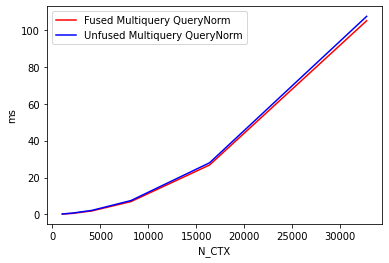

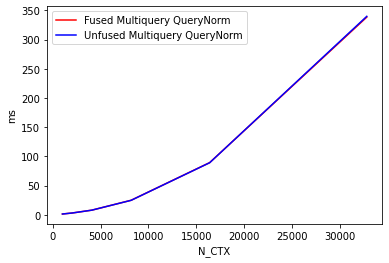

In [3]:
bench_multiquery_querynorm_attention.run(save_path='.', print_data=True)